## Debrief on Warmup Project Model Iteration 1

This notebook provides some hints for how students can improve.  I based these off of what I saw from everyone in the model iteration 1 notebooks from the Titanic project.  The suggestions are for both improving model performance as well as improving communcation / readability.

### Create a Data Cleaning Function

Usually you will want to apply the same set of transformations to be your training and test data.  When using something like Kaggle, these two sets are typically in different csv files.  This means that you will be tempted to create different data frames for train / test, and then do some cut-and-paste code to replicate your cleaning code for the training data for your testing data.  Instead of doing this, let's make a function to factor out the common work.

#### Code Without a Data Cleaning Function (before)

In [72]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load and then clean the traning data
titanic_train = pd.read_csv('../../datasets/titanic_train.csv')
titanic_train["Age"] = titanic_train["Age"].fillna(titanic_train["Age"].median())

titanic_train.loc[titanic_train["Sex"] == "male", "Sex"] = 0
titanic_train.loc[titanic_train["Sex"] == "female", "Sex"] = 1

titanic_train["Embarked"] = titanic_train["Embarked"].fillna("S")
titanic_train.loc[titanic_train["Embarked"] == "S", "Embarked"] = 0
titanic_train.loc[titanic_train["Embarked"] == "C", "Embarked"] = 1
titanic_train.loc[titanic_train["Embarked"] == "Q", "Embarked"] = 2

titanic_train["Fare"] = titanic_train["Fare"].fillna(titanic_train["Fare"].median())


# load and then clean the testing data
titanic_test = pd.read_csv('../../datasets/titanic_test.csv')
titanic_test["Age"] = titanic_test["Age"].fillna(titanic_test["Age"].median())

titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1

titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())

#### Code Without a Data Cleaning Function (after)

This code is from Anne Loverso's notebook.

In [73]:
def clean_data(data, age_filler):
    data.Age = data.Age.fillna(age_filler)
    data.Fare = data.Fare.fillna(data.Fare.median())
    data.loc[data.Sex == "female", "Sex"] = 1
    data.loc[data.Sex == "male", "Sex"] = 0
    data.Embarked = data.Embarked.fillna("S")
    data.loc[data.Embarked == "S", "Embarked"] = 0
    data.loc[data.Embarked == "C", "Embarked"] = 1
    data.loc[data.Embarked == "Q", "Embarked"] = 2
    return data

titanic_train = pd.read_csv('../../datasets/titanic_train.csv')
titanic_train = clean_data(titanic_train, titanic_train.Age.median())

titanic_test = pd.read_csv('../../datasets/titanic_test.csv')
titanic_test = clean_data(titanic_test, titanic_train.Age.median())

### Using pandas.get_dummmies

A lot of times you want to convert from a categorical variable to a "one-hot" encoding.  A one-hot encoding is when you use a separate binary column to indicate whether or not the categorical variable takes on a particular value.  Here is what that would look like if we applied this technique to the data titanic data.

In [74]:
def clean_data_dummies(data, age_filler):
    data.Age = data.Age.fillna(age_filler)
    data.Fare = data.Fare.fillna(data.Fare.median())
    data = pd.concat((data, pd.get_dummies(data.Sex, prefix="sex")), axis=1)
    data.Embarked = data.Embarked.fillna("S")
    data = pd.concat((data, pd.get_dummies(data.Embarked, prefix="embarked")), axis=1)
    return data

titanic_train_dummies = pd.read_csv('../../datasets/titanic_train.csv')
titanic_train_dummies = clean_data_dummies(titanic_train_dummies,
                                           titanic_train_dummies.Age.median())

titanic_test_dummies = pd.read_csv('../../datasets/titanic_test.csv')
titanic_test_dummies = clean_data_dummies(titanic_test_dummies,
                                          titanic_train_dummies.Age.median())

titanic_train_dummies.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked',
       u'sex_female', u'sex_male', u'embarked_C', u'embarked_Q',
       u'embarked_S'],
      dtype='object')

There is a small difference between this and the original representation of the data.  Specifically, before we represented S as 0, C as 1, and Q as 2 and now we represent them as separate binary columns.  What are the implications of this change?  Under what conditions might it matter more or less?

### Running Multiple Cross Validation Trials

Another thing I saw consistently was that people would find an improvement when using cross_val_score and then they would not see the same gain on Kaggle.  One way to get a better estimate of how likely an improvement is to carry over, is to do more stringent cross validation.

In [75]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression()
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

without_dummies = cross_validation.cross_val_score(alg,
                                                   titanic_train[predictors],
                                                   titanic_train.Survived)

predictors_dummies = ["Pclass",
                      "sex_female",
                      "sex_male",
                      "Age",
                      "SibSp",
                      "Parch",
                      "Fare",
                      "embarked_S",
                      "embarked_C",
                      "embarked_Q"]
with_dummies = cross_validation.cross_val_score(alg,
                                                titanic_train_dummies[predictors_dummies],
                                                titanic_train_dummies.Survived)

with_dummies.mean() - without_dummies.mean()

0.0011223344556678949

To see the durability of this finding, let's do a bunch of trials of three-fold cross validation.

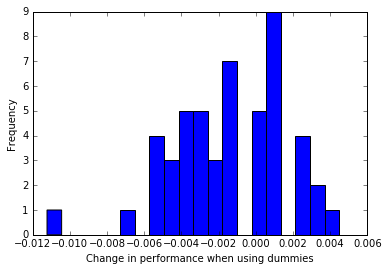

In [92]:
def do_trial(data1, predictors1, data2, predictors2):
    alg = LogisticRegression()
    # change Shuffle to False to see how this affects the conclusions
    cv = cross_validation.StratifiedKFold(data1.Survived, 3, shuffle=True)
    score1 = cross_validation.cross_val_score(alg, data1[predictors1], data1.Survived, cv=cv)
    score2 = cross_validation.cross_val_score(alg, data2[predictors2], data2.Survived, cv=cv)
    return score1.mean() - score2.mean()

results = []
n_trials = 50
for i in range(n_trials):
    results.append(do_trial(titanic_train_dummies, predictors_dummies, titanic_train, predictors))
    
plt.hist(results, bins=20)
plt.xlabel('Change in performance when using dummies')
plt.ylabel('Frequency')
plt.show()

In contrast if we look at something with some real signal, we will see a different pattern.  Let's look at adding whether or not the passenger was a child (age less than or equal to 12 is likely to have a positive effect on the results).

In [91]:
titanic_train["is_child"] = (titanic_train.Age <= 12).astype(float)
titanic_train.is_child.value_counts()

0    822
1     69
Name: is_child, dtype: int64

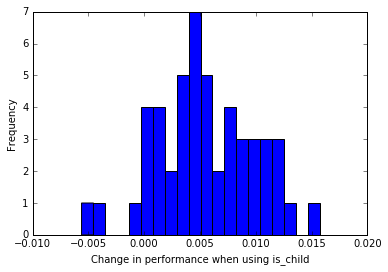

In [96]:
results = []
n_trials = 50
for i in range(n_trials):
    results.append(do_trial(titanic_train,
                            predictors + ["is_child"],
                            titanic_train,
                            predictors))
    
plt.hist(results, bins=20)
plt.xlabel('Change in performance when using is_child')
plt.ylabel('Frequency')
plt.show()

### Examining Model Mistakes

Some folks used analysis of the model's mistakes as a way to point the way to potential improvements.  Looking at individual mistakes can be good, but it is usually easier to look at overall trends of mistakes to get a better sense of how thing can be improved.  To see this in action, let's look at how we might use this analysis to point the way to using `is_child` as a good predictor to add to our model.

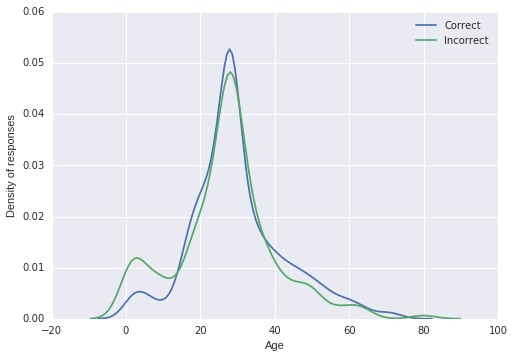

In [166]:
import seaborn as sns
# setting shuffle=False for repeatability
cv = cross_validation.StratifiedKFold(titanic_train.Survived, 3, shuffle=False)
correct = []
indices = []

for train, test in cv:
    model = LogisticRegression()
    X = titanic_train.iloc[train, :]
    X = X[predictors]
    y = titanic_train.iloc[train, :].Survived
    model.fit(X, y)
    
    X_test = titanic_train.iloc[test, :]
    X_test = X_test[predictors]
    y_test = titanic_train.iloc[test, :].Survived

    indices.extend(titanic_train.iloc[test,:].index)
    correct.extend(model.predict(X_test) == y_test)

is_correct = pd.Series(correct, index=indices)

# note that distplot is a density (meaning it is normalized).  This facilitates
# direct comparision between the two populations
sns.distplot(titanic_train[is_correct].Age, hist=False, label="Correct")
sns.distplot(titanic_train[~is_correct].Age, hist=False, label="Incorrect")
sns.plt.ylabel('Density of responses')
sns.plt.show()

### Ways to Transform the Age Variable

We'll do a brainstorm on this on the board.

### Improving Readability


#### Include an example of an abstract that describes the contents of the ipython notebook.

Example 1: 
> In order to learn the basics of kaggle, I start this first model iteration of the Titanic warmup project. Basically, I followed along the tutorial in https://www.dataquest.io/mission/74/getting-started-with-kaggle and created a simple linear regression and logistic regression to have a simple machine learning model for the survival data in Titanic event.

Example 2:
> This code goes through the process of training the algorithm to use the predictors I think are most important. These are passenger class, sex, age, family members, fare, and the location the passengers embarked from.This code does a large amount of preprocessing, mostly in the form of converting non integer values into integer values that the computer can then analyze. I also had to replace a few column's nan values with either an educated guess or the average median of the rest of the data, which serves to make the algorithm stronger without compromising on data integrity.

Example 3:
> In this notebook, we'll be building a predictive model for survival on the titanic based on training data provided by kaggle. This is part of the Warmup Project for Data Science 2016.

Example 4:
> In this notebook, I begin with a model that is dervied from experience using DataQuest, and then annotate a variety of revisions tried since. Accuracies are also reported.

#### Avoid cut and pasting code when possible

Putting all imports and read_csv's in each cell is tempting to improve repeatability, however, it comes at the cost of readability.  As you gain more comfort with Jupyter notebooks you should be able to find a sweetspot that serves both goals well.

#### Include appropriate narration

Including narration / explanation of the data quest model increased my confidence that you understood it. This is always a good idea for building confidence in your reader.

#### Be thoughtful in sequencing

Think about the sequence of your explanation of an analysis, your code, and your interpretation.  I saw some folks that would put code, and then only after the code block explain what the code was doing.